In [ ]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
import torch
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Install ultralytics
subprocess.run(["pip", "install", "ultralytics"])
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install wandb -qU


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 60.9 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login(key='bbc7a7a7ee82211f98ada220673a9aaf3f325335')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: arunshanmugam49 (arunshanmugam49-niloblog). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# File paths
image_dir = r"/content/drive/MyDrive/arun/images"
csv_path = r"/content/drive/MyDrive/faces.csv"
output_dir = "/content/output"


In [ ]:
# Load the dataset
faces_df = pd.read_csv(csv_path)

In [ ]:
print(faces_df.head())
print(faces_df.info())
print(faces_df.describe())

     image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331
3  00001736.jpg    626     417  147   14   519  303
4  00003121.jpg    626     418  462   60   599  166
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  3350 non-null   object
 1   width       3350 non-null   int64 
 2   height      3350 non-null   int64 
 3   x0          3350 non-null   int64 
 4   y0          3350 non-null   int64 
 5   x1          3350 non-null   int64 
 6   y1          3350 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 183.3+ KB
None
             width       height           x0           y0           x1  \
count  3350.000000  3350.000000  3350.000000  3350.000000  3350.000000   
mean    967.96716

In [ ]:
import nbformat
print(nbformat.__version__)


5.10.4


In [ ]:
# Plot distribution of image widths and heights using Plotly
fig = px.histogram(faces_df, x='width', nbins=50, title='Distribution of Image Widths',
                   labels={'width': 'Image Width'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='height', nbins=50, title='Distribution of Image Heights',
                   labels={'height': 'Image Height'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

In [ ]:
# Plot distribution of bounding box coordinates using Plotly
fig = px.histogram(faces_df, x='x0', nbins=50, title='Distribution of X0 Coordinates',
                   labels={'x0': 'X0 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='y0', nbins=50, title='Distribution of Y0 Coordinates',
                   labels={'y0': 'Y0 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='x1', nbins=50, title='Distribution of X1 Coordinates',
                   labels={'x1': 'X1 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

fig = px.histogram(faces_df, x='y1', nbins=50, title='Distribution of Y1 Coordinates',
                   labels={'y1': 'Y1 Coordinate'}, template='plotly_dark')
fig.update_layout(title_font=dict(size=24, family='Arial', color='white'))
fig.show()

In [ ]:
# Convert bounding box coordinates to YOLO format (normalized x_center, y_center, width, height)
def convert_to_yolo(row):
    dw = 1. / row['width']
    dh = 1. / row['height']
    x = (row['x0'] + row['x1']) / 2.0
    y = (row['y0'] + row['y1']) / 2.0
    w = row['x1'] - row['x0']
    h = row['y1'] - row['y0']
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return x, y, w, h

faces_df[['x', 'y', 'w', 'h']] = faces_df.apply(convert_to_yolo, axis=1, result_type='expand')

In [ ]:
!python train.py --data your_data.yaml --cfg yolov5s.yaml --weights yolov5s.pt --batch-size 16

python3: can't open file '/content/train.py': [Errno 2] No such file or directory


In [ ]:
# Split the dataset into train and validation sets
train_df, val_df = train_test_split(faces_df, test_size=0.3, random_state=42)

In [ ]:
# Create YOLO annotation files
annotations_dir = os.path.join(output_dir, 'annotations')
os.makedirs(annotations_dir, exist_ok=True)

for idx, row in faces_df.iterrows():
    annotation_path = os.path.join(annotations_dir, row['image_name'].replace('.jpg', '.txt'))
    with open(annotation_path, 'w') as f:
        f.write(f"0 {row['x']} {row['y']} {row['w']} {row['h']}\n")

In [ ]:
# Function to create YOLO annotation files
def create_annotations(df, annotations_dir):
    os.makedirs(annotations_dir, exist_ok=True)
    for idx, row in df.iterrows():
        annotation_path = os.path.join(annotations_dir, row['image_name'].replace('.jpg', '.txt'))
        with open(annotation_path, 'w') as f:
            f.write(f"0 {row['x']} {row['y']} {row['w']} {row['h']}\n")

# Create YOLO annotation files for train and validation sets
train_annotations_dir = os.path.join(output_dir, 'train', 'labels')
val_annotations_dir = os.path.join(output_dir, 'val', 'labels')

create_annotations(train_df, train_annotations_dir)
create_annotations(val_df, val_annotations_dir)

In [ ]:
# Image preprocessing
def preprocess_images(image_list, source_dir, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for img_name in image_list:
        img_path = os.path.join(source_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            target_path = os.path.join(target_dir, img_name)
            cv2.imwrite(target_path, img)

train_images_dir = os.path.join(output_dir, 'train', 'images')
val_images_dir = os.path.join(output_dir, 'val', 'images')

preprocess_images(train_df['image_name'].tolist(), image_dir, train_images_dir)
preprocess_images(val_df['image_name'].tolist(), image_dir, val_images_dir)

# Verify annotation files
print("Train annotations sample:")
print(os.listdir(train_annotations_dir)[:5])

print("Validation annotations sample:")
print(os.listdir(val_annotations_dir)[:5])

Train annotations sample:
['00000706.txt', '00000704.txt', '00000272.txt', '00001177.txt', '00001660.txt']
Validation annotations sample:
['00000704.txt', '00003451.txt', '00001236.txt', '00000539.txt', '00001940.txt']


In [ ]:
yolo_model = YOLO('yolov8n.yaml')

In [ ]:
# Define the data.yaml file content dynamically
class_names = ['face']
data_yaml_content = f"""
train: {train_images_dir}
val: {val_images_dir}
nc: {len(class_names)}
names: {class_names}
"""

# Save the data.yaml file
data_yaml_path = os.path.join(output_dir, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)

In [ ]:

# Train the model
yolo_model.train(data=data_yaml_path, epochs=50, imgsz=224)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/output/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:00<00:00, 31.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/output/train/labels... 1672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1672/1672 [00:02<00:00, 620.14it/s]

train: New cache created: /content/output/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning:

A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.

val: Scanning /content/output/val/labels... 837 images, 0 backgrounds, 0 corrupt: 100%|██████████| 837/837 [00:00<00:00, 895.40it/s] 

val: New cache created: /content/output/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      4.329      3.471      3.853         15        224: 100%|██████████| 105/105 [04:14<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:47<00:00,  1.76s/it]

                   all        837        837    0.00634      0.407    0.00732    0.00249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      3.129      2.531      2.761         17        224: 100%|██████████| 105/105 [04:04<00:00,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.70s/it]

                   all        837        837      0.218      0.291      0.162     0.0538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.809      2.219      2.382         16        224: 100%|██████████| 105/105 [04:09<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.70s/it]

                   all        837        837      0.246      0.331      0.184      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.547      2.009      2.143         16        224: 100%|██████████| 105/105 [04:01<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:41<00:00,  1.55s/it]


                   all        837        837      0.371      0.436      0.328      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G       2.37      1.895      2.026         19        224: 100%|██████████| 105/105 [03:43<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:46<00:00,  1.71s/it]

                   all        837        837      0.404      0.434       0.36      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.236      1.829      1.924         18        224: 100%|██████████| 105/105 [04:01<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.70s/it]

                   all        837        837      0.384       0.49      0.391      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.127      1.783      1.854         20        224: 100%|██████████| 105/105 [04:02<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.70s/it]

                   all        837        837      0.448       0.45      0.395      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.095      1.728      1.825         17        224: 100%|██████████| 105/105 [03:52<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:41<00:00,  1.55s/it]


                   all        837        837      0.376       0.48      0.389      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.974      1.679      1.749         21        224: 100%|██████████| 105/105 [03:30<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:38<00:00,  1.44s/it]

                   all        837        837      0.425      0.545      0.468      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.967      1.672      1.725         15        224: 100%|██████████| 105/105 [04:02<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:44<00:00,  1.65s/it]

                   all        837        837      0.395      0.489      0.391      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.911      1.622      1.669         21        224: 100%|██████████| 105/105 [04:01<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:41<00:00,  1.54s/it]

                   all        837        837      0.456      0.471      0.442      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.866      1.582      1.668         13        224: 100%|██████████| 105/105 [03:36<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:39<00:00,  1.47s/it]

                   all        837        837      0.508       0.54      0.526      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.787      1.538      1.614         22        224: 100%|██████████| 105/105 [03:33<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:40<00:00,  1.51s/it]

                   all        837        837      0.532      0.528       0.58      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.827      1.522      1.626         15        224: 100%|██████████| 105/105 [03:33<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:39<00:00,  1.45s/it]


                   all        837        837      0.526      0.538      0.542      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.766      1.488      1.604         13        224: 100%|██████████| 105/105 [04:01<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:47<00:00,  1.75s/it]

                   all        837        837      0.614      0.528      0.601      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.762      1.472      1.574         11        224: 100%|██████████| 105/105 [04:07<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:47<00:00,  1.75s/it]

                   all        837        837      0.562      0.602      0.626      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.712      1.428       1.55         19        224: 100%|██████████| 105/105 [04:07<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:44<00:00,  1.65s/it]

                   all        837        837      0.607      0.575      0.641      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.729      1.416      1.559         20        224: 100%|██████████| 105/105 [04:03<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:48<00:00,  1.78s/it]

                   all        837        837      0.591      0.572      0.632      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.712      1.402      1.554         10        224: 100%|██████████| 105/105 [04:03<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:44<00:00,  1.65s/it]

                   all        837        837      0.699      0.596      0.695      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G       1.67      1.364      1.517         18        224: 100%|██████████| 105/105 [03:39<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:38<00:00,  1.42s/it]


                   all        837        837      0.644      0.597      0.694      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.641      1.339      1.506         19        224: 100%|██████████| 105/105 [03:33<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.70s/it]

                   all        837        837      0.701      0.577      0.699      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.603      1.308      1.481         18        224: 100%|██████████| 105/105 [04:03<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.69s/it]

                   all        837        837      0.693      0.615      0.716       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.611      1.306      1.473         15        224: 100%|██████████| 105/105 [03:59<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:38<00:00,  1.44s/it]


                   all        837        837      0.679      0.565       0.69      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.622       1.31      1.473         13        224: 100%|██████████| 105/105 [03:46<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:44<00:00,  1.65s/it]

                   all        837        837      0.685      0.624      0.729      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.573      1.279      1.448         15        224: 100%|██████████| 105/105 [04:00<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.69s/it]

                   all        837        837      0.645      0.631      0.722      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.582      1.254       1.46         17        224: 100%|██████████| 105/105 [03:59<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:47<00:00,  1.75s/it]

                   all        837        837      0.707      0.628      0.736      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.566      1.262      1.461         17        224: 100%|██████████| 105/105 [04:01<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:44<00:00,  1.66s/it]

                   all        837        837      0.614      0.558      0.615      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G       1.56      1.254      1.438         16        224: 100%|██████████| 105/105 [04:02<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.68s/it]

                   all        837        837      0.691      0.622      0.721      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.532      1.219       1.41         13        224: 100%|██████████| 105/105 [04:02<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.70s/it]

                   all        837        837      0.744      0.596       0.74      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.539       1.22      1.426         17        224: 100%|██████████| 105/105 [04:06<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:44<00:00,  1.65s/it]

                   all        837        837      0.668      0.649      0.705      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.525      1.216      1.437         17        224: 100%|██████████| 105/105 [04:04<00:00,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:46<00:00,  1.72s/it]

                   all        837        837      0.664      0.591      0.681      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.512      1.193      1.421         17        224: 100%|██████████| 105/105 [04:01<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.68s/it]

                   all        837        837      0.739      0.632      0.764      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.492      1.179      1.417         15        224: 100%|██████████| 105/105 [04:01<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.70s/it]

                   all        837        837      0.667       0.64      0.743      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.482      1.171      1.406         16        224: 100%|██████████| 105/105 [04:03<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:46<00:00,  1.71s/it]

                   all        837        837      0.766      0.596      0.769      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.497      1.177      1.407         24        224: 100%|██████████| 105/105 [03:32<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:39<00:00,  1.45s/it]

                   all        837        837       0.66      0.637      0.735      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.465       1.16      1.398         21        224: 100%|██████████| 105/105 [03:32<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:40<00:00,  1.49s/it]

                   all        837        837      0.711      0.635      0.757      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.471      1.156      1.382         13        224: 100%|██████████| 105/105 [03:28<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:39<00:00,  1.48s/it]


                   all        837        837      0.747      0.593       0.75      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.459      1.135       1.39         17        224: 100%|██████████| 105/105 [03:29<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:38<00:00,  1.44s/it]

                   all        837        837      0.736       0.63      0.773      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.447      1.124      1.366         14        224: 100%|██████████| 105/105 [03:32<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:40<00:00,  1.51s/it]


                   all        837        837      0.665      0.643      0.737      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.435      1.111       1.38          8        224: 100%|██████████| 105/105 [03:38<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:41<00:00,  1.53s/it]

                   all        837        837      0.735      0.634      0.758       0.47


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.265          1      1.332          8        224: 100%|██████████| 105/105 [03:34<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:39<00:00,  1.46s/it]


                   all        837        837      0.718      0.636      0.766      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.232     0.9129        1.3          8        224: 100%|██████████| 105/105 [03:30<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:39<00:00,  1.46s/it]

                   all        837        837      0.728      0.654      0.793      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.234     0.8955      1.319          8        224: 100%|██████████| 105/105 [03:31<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:40<00:00,  1.49s/it]


                   all        837        837      0.736       0.67      0.809      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.203     0.8779      1.309          8        224: 100%|██████████| 105/105 [03:33<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:38<00:00,  1.44s/it]


                   all        837        837      0.794       0.62      0.801      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.203     0.8608       1.29          8        224: 100%|██████████| 105/105 [03:32<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:40<00:00,  1.49s/it]

                   all        837        837      0.816      0.615      0.809      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.179      0.843      1.286          8        224: 100%|██████████| 105/105 [03:30<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:41<00:00,  1.52s/it]

                   all        837        837      0.808      0.624      0.807      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.189     0.8492       1.29          8        224: 100%|██████████| 105/105 [03:29<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:38<00:00,  1.44s/it]

                   all        837        837      0.777       0.64      0.813      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.177     0.8391      1.267          8        224: 100%|██████████| 105/105 [03:35<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:41<00:00,  1.55s/it]


                   all        837        837      0.776      0.641      0.806      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.163     0.8383      1.268          8        224: 100%|██████████| 105/105 [03:37<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:40<00:00,  1.49s/it]

                   all        837        837      0.815      0.619      0.806      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.159     0.8339       1.28          8        224: 100%|██████████| 105/105 [03:32<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:40<00:00,  1.51s/it]

                   all        837        837      0.792      0.635      0.814      0.528



50 epochs completed in 3.797 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:38<00:00,  1.42s/it]


                   all        837        837      0.734       0.67       0.81      0.531
Speed: 0.3ms preprocess, 32.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d863ce74550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 


image 1/1 /content/output/val/images/00002573.jpg: 192x224 2 faces, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 224)


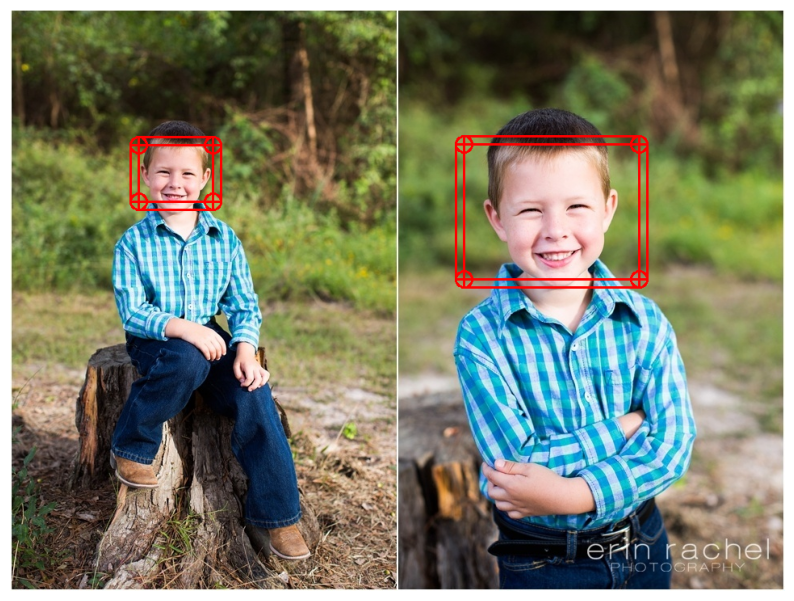


image 1/1 /content/output/val/images/00000811.jpg: 224x224 1 face, 66.2ms
Speed: 1.5ms preprocess, 66.2ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 224)


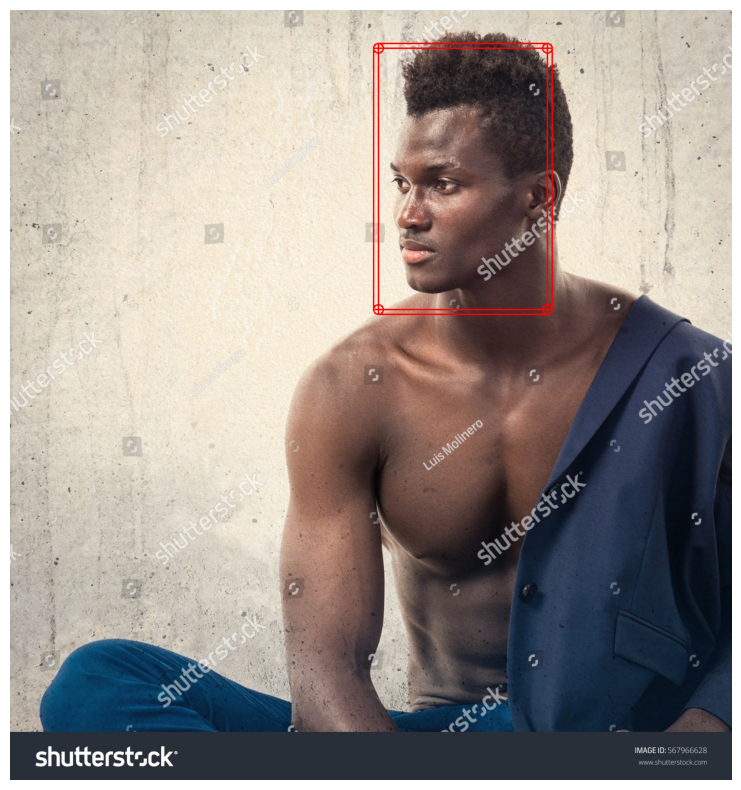


image 1/1 /content/output/val/images/00002499.jpg: 192x224 1 face, 57.0ms
Speed: 1.2ms preprocess, 57.0ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 224)


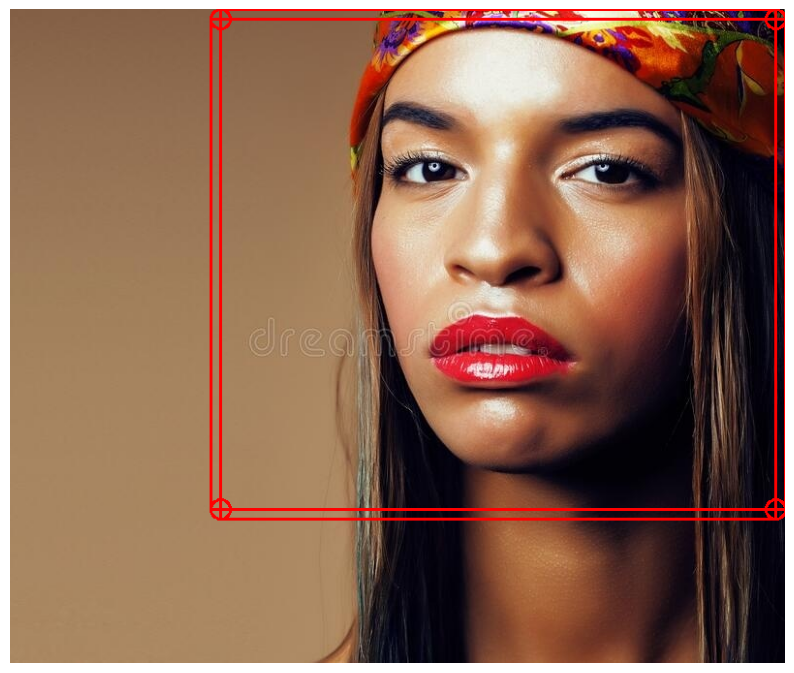


image 1/1 /content/output/val/images/00002860.jpg: 192x224 2 faces, 60.1ms
Speed: 1.2ms preprocess, 60.1ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 224)


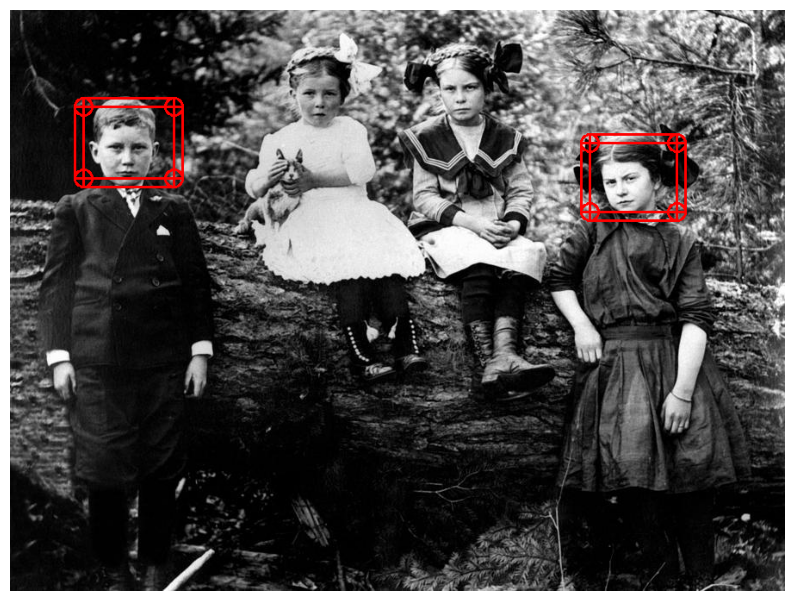


image 1/1 /content/output/val/images/00000851.jpg: 224x224 (no detections), 90.9ms
Speed: 1.2ms preprocess, 90.9ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)


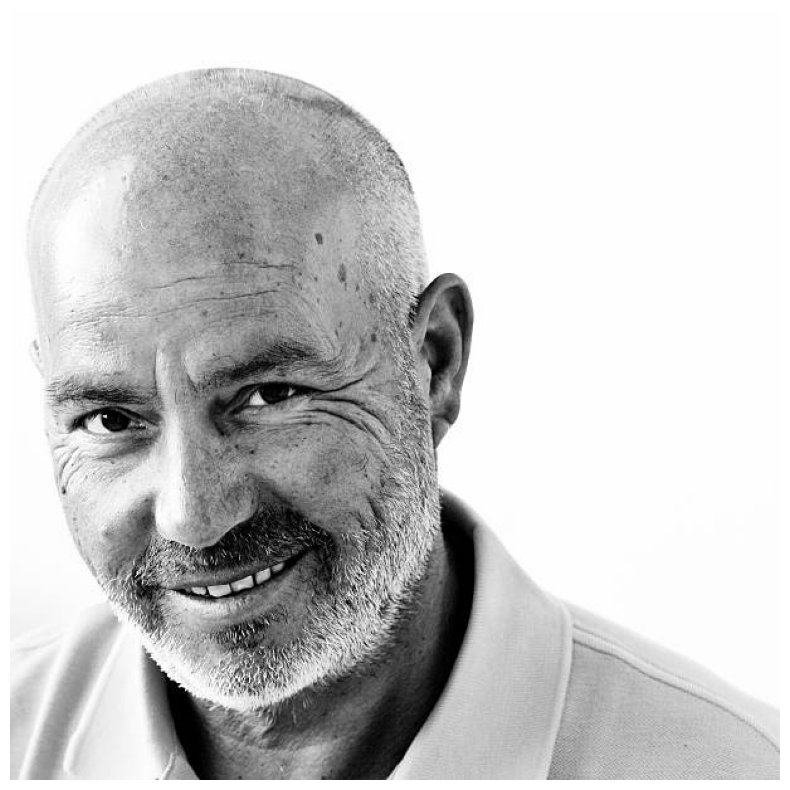


image 1/1 /content/output/val/images/00001130.jpg: 224x160 1 face, 57.1ms
Speed: 1.4ms preprocess, 57.1ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 160)


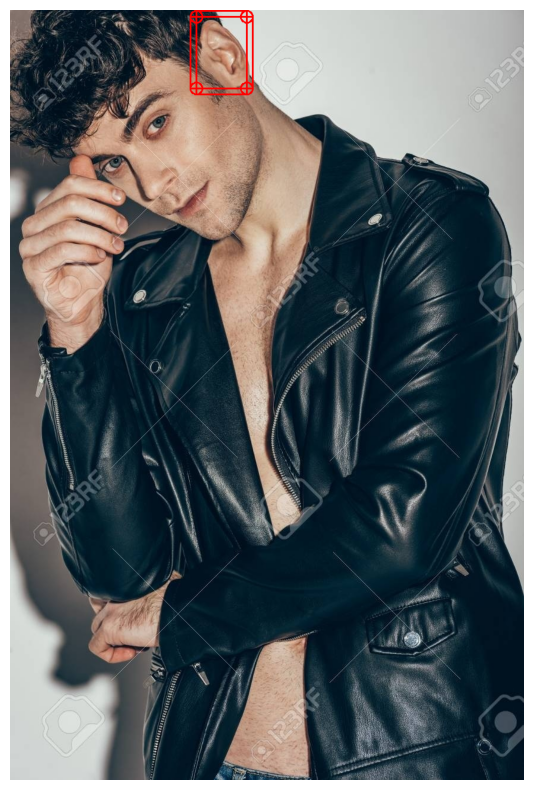


image 1/1 /content/output/val/images/00003187.jpg: 160x224 1 face, 73.1ms
Speed: 2.4ms preprocess, 73.1ms inference, 1.1ms postprocess per image at shape (1, 3, 160, 224)


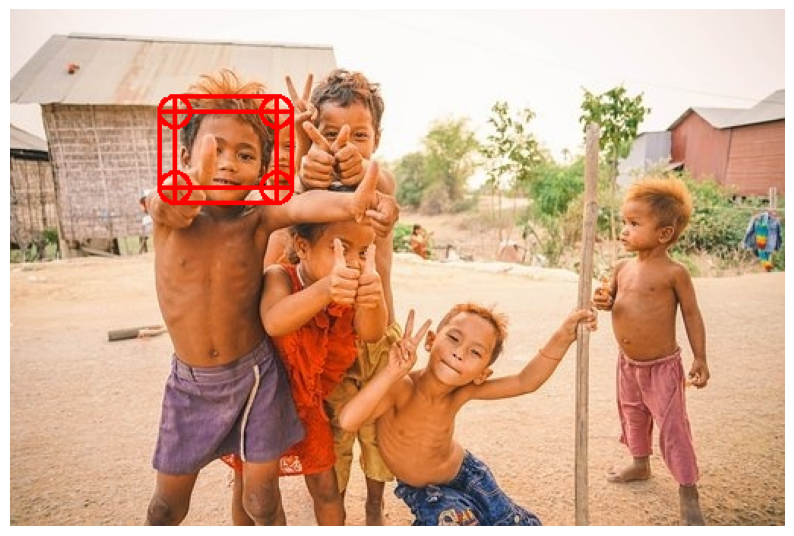


image 1/1 /content/output/val/images/00001178.jpg: 192x224 1 face, 74.6ms
Speed: 1.2ms preprocess, 74.6ms inference, 1.3ms postprocess per image at shape (1, 3, 192, 224)


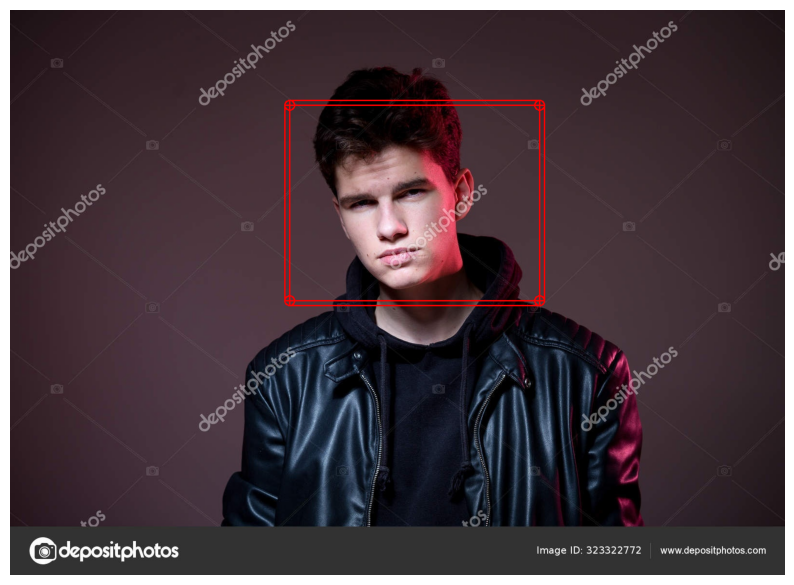


image 1/1 /content/output/val/images/00003035.jpg: 192x224 2 faces, 55.6ms
Speed: 1.1ms preprocess, 55.6ms inference, 1.2ms postprocess per image at shape (1, 3, 192, 224)


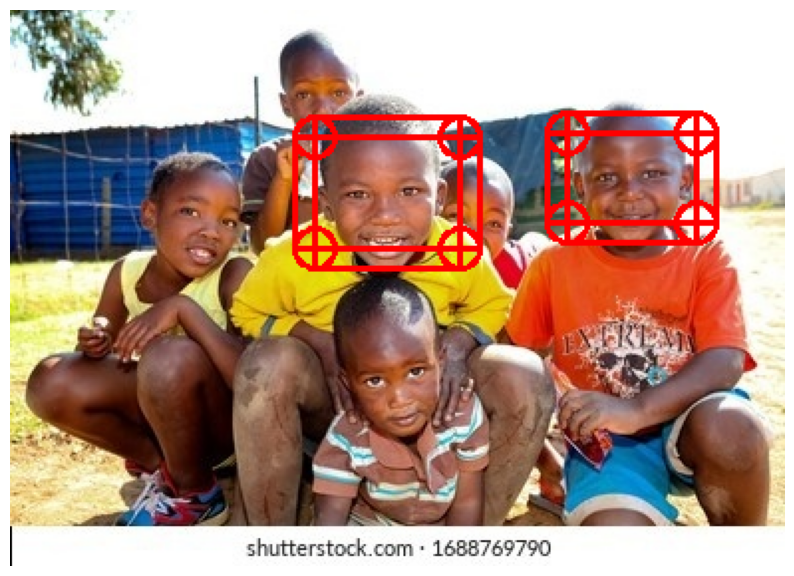


image 1/1 /content/output/val/images/00003055.jpg: 192x224 2 faces, 78.6ms
Speed: 7.3ms preprocess, 78.6ms inference, 2.1ms postprocess per image at shape (1, 3, 192, 224)


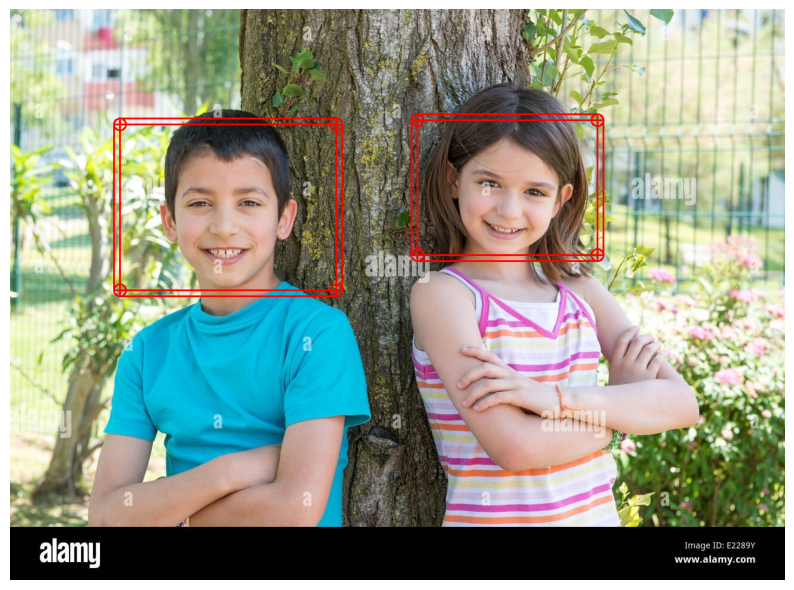

Process completed. Outputs are stored in: /content/output


In [ ]:
# Function to draw rounded rectangle
def draw_rounded_rectangle(img, start_point, end_point, color, thickness, radius):
    x1, y1 = start_point
    x2, y2 = end_point
    img = cv2.rectangle(img, (x1 + radius, y1), (x2 - radius, y2), color, thickness)
    img = cv2.rectangle(img, (x1, y1 + radius), (x2, y2 - radius), color, thickness)
    img = cv2.circle(img, (x1 + radius, y1 + radius), radius, color, thickness)
    img = cv2.circle(img, (x2 - radius, y1 + radius), radius, color, thickness)
    img = cv2.circle(img, (x1 + radius, y2 - radius), radius, color, thickness)
    img = cv2.circle(img, (x2 - radius, y2 - radius), radius, color, thickness)
    return img

# Display 10 sample images with detection results
def display_samples_with_detections(model, images_dir, samples=10):
    sample_images = os.listdir(images_dir)[:samples]
    for img_name in sample_images:
        img_path = os.path.join(images_dir, img_name)
        results = model(img_path)[0]  # Get the first (and only) Results object
        img = cv2.imread(img_path)
        for box in results.boxes.xyxy.cpu().numpy():  # x1, y1, x2, y2
            x1, y1, x2, y2 = map(int, box)
            img = draw_rounded_rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2, 10)  # Red color, thickness 2, radius 10
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

display_samples_with_detections(yolo_model, val_images_dir)

print("Process completed. Outputs are stored in:", output_dir)

In [ ]:
import torch

# Sample data: ground truth and predicted bounding boxes with class labels
# Format: (x_min, y_min, x_max, y_max, class_id)
ground_truth_boxes = [
    [50, 50, 150, 150, 1],
    [30, 30, 100, 100, 2]
]

predicted_boxes = [
    [55, 55, 145, 145, 1],
    [35, 35, 90, 90, 2],
    [150, 150, 200, 200, 1]  # An example of a false positive
]

# Convert to torch tensors
ground_truth_boxes = torch.tensor(ground_truth_boxes, dtype=torch.float32)
predicted_boxes = torch.tensor(predicted_boxes, dtype=torch.float32)

def calculate_iou(box1, box2):
    """ Calculate Intersection over Union (IoU) between two bounding boxes """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Area of intersection
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Area of both bounding boxes
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Area of union
    union = area_box1 + area_box2 - intersection

    # Compute IoU
    iou = intersection / union if union > 0 else 0.0

    return iou

def calculate_map(pred_boxes, true_boxes, iou_threshold=0.5):
    """ Calculate mean Average Precision (mAP) for object detection """
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched_gt_boxes = []  # Track matched ground truth boxes to avoid duplicates

    for pred_box in pred_boxes:
        iou_max = 0
        matched_gt_box = None

        for gt_box in true_boxes:
            if pred_box[4] == gt_box[4]:  # Check if class IDs match
                iou = calculate_iou(pred_box[:4], gt_box[:4])
                if iou > iou_max:
                    iou_max = iou
                    matched_gt_box = gt_box

        if iou_max >= iou_threshold and matched_gt_box is not None:
            # Check if matched_gt_box has already been matched
            if not any(torch.equal(matched_gt_box, mb) for mb in matched_gt_boxes):
                true_positives += 1
                matched_gt_boxes.append(matched_gt_box)  # Mark this GT box as matched
        else:
            false_positives += 1

    # Remaining ground truth boxes are false negatives
    false_negatives = len(true_boxes) - len(matched_gt_boxes)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    return precision, recall

# Calculate mAP
precision, recall = calculate_map(predicted_boxes, ground_truth_boxes)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')


Precision: 0.6667, Recall: 1.0000


In [ ]:
yolo_model.export(format="onnx")

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 5, 1029) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 189.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 236.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 161.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 182.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 197.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 12.9s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with 

'runs/detect/train/weights/best.onnx'